##Train a ResNet-18 classifier on CIFAR-100 using PyTorch

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models

from pathlib import Path
from time import time


In [2]:
# CONFIG
DATA_DIR = "./data"
BATCH_SIZE = 128
NUM_WORKERS = 4
NUM_EPOCHS = 50
LR = 0.1
WEIGHT_DECAY = 5e-4
MOMENTUM = 0.9
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
PRINT_EVERY = 1

print("Using device:", DEVICE)

# CIFAR-100 stats
CIFAR100_MEAN = (0.5071, 0.4867, 0.4408)
CIFAR100_STD = (0.2675, 0.2565, 0.2761)

#TRANSFORMS
train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(CIFAR100_MEAN, CIFAR100_STD),
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(CIFAR100_MEAN, CIFAR100_STD),
])

# DATASETS
train_dataset = datasets.CIFAR100(
    root=DATA_DIR, train=True, download=True, transform=train_transform
)
test_dataset = datasets.CIFAR100(
    root=DATA_DIR, train=False, download=True, transform=test_transform
)

# DATALOADERS
train_loader = DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True,
    num_workers=NUM_WORKERS, pin_memory=True
)
test_loader = DataLoader(
    test_dataset, batch_size=BATCH_SIZE, shuffle=False,
    num_workers=NUM_WORKERS, pin_memory=True
)


Using device: cuda


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
def make_resnet18_cifar100():
    model = models.resnet18(weights=None)  # no pretraining, we train from scratch

    model.conv1 = nn.Conv2d(
        3, 64, kernel_size=3, stride=1, padding=1, bias=False
    )
    model.maxpool = nn.Identity()

    # replace final FC to output 100 classes
    num_features = model.fc.in_features
    model.fc = nn.Linear(num_features, 100)

    return model

model = make_resnet18_cifar100().to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(
    model.parameters(), lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY
)

# we use cosine annealing scheduler (common on CIFAR)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS)

print("Number of parameters:", sum(p.numel() for p in model.parameters()))


Number of parameters: 11220132


In [4]:
def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, targets in loader:
        inputs = inputs.to(device, non_blocking=True)
        targets = targets.to(device, non_blocking=True)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        correct += predicted.eq(targets).sum().item()
        total += targets.size(0)

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc


@torch.no_grad()
def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, targets in loader:
        inputs = inputs.to(device, non_blocking=True)
        targets = targets.to(device, non_blocking=True)

        outputs = model(inputs)
        loss = criterion(outputs, targets)

        running_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        correct += predicted.eq(targets).sum().item()
        total += targets.size(0)

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc


In [ ]:
save_dir = Path("./checkpoints")
save_dir.mkdir(parents=True, exist_ok=True)
best_ckpt_path = save_dir / "resnet18_cifar100_best.pth"

train_losses, train_accs = [], []
test_losses, test_accs = [], []

best_test_acc = 0.0
start_time = time()

for epoch in range(1, NUM_EPOCHS + 1):
    train_loss, train_acc = train_one_epoch(
        model, train_loader, criterion, optimizer, DEVICE
    )
    test_loss, test_acc = evaluate(
        model, test_loader, criterion, DEVICE
    )
    scheduler.step()

    train_losses.append(train_loss)
    train_accs.append(train_acc)
    test_losses.append(test_loss)
    test_accs.append(test_acc)

    if test_acc > best_test_acc:
        best_test_acc = test_acc
        torch.save(
            {
                "epoch": epoch,
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "best_test_acc": best_test_acc,
            },
            best_ckpt_path,
        )

    if epoch % PRINT_EVERY == 0:
        print(
            f"Epoch [{epoch}/{NUM_EPOCHS}] "
            f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc*100:.2f}% || "
            f"Test Loss: {test_loss:.4f} | Test Acc: {test_acc*100:.2f}% "
            f"(Best: {best_test_acc*100:.2f}%)"
        )

total_time = time() - start_time
print(f"Training finished in {total_time/60:.1f} min.")
print(f"Best test accuracy: {best_test_acc*100:.2f}%")


Epoch [1/50] Train Loss: 3.9239 | Train Acc: 9.45% || Test Loss: 3.4969 | Test Acc: 15.31% (Best: 15.31%)
Epoch [2/50] Train Loss: 3.2645 | Train Acc: 19.80% || Test Loss: 3.0975 | Test Acc: 23.10% (Best: 23.10%)
Epoch [3/50] Train Loss: 2.7288 | Train Acc: 29.80% || Test Loss: 2.5759 | Test Acc: 32.42% (Best: 32.42%)
Epoch [4/50] Train Loss: 2.2903 | Train Acc: 38.52% || Test Loss: 2.3509 | Test Acc: 38.58% (Best: 38.58%)
Epoch [5/50] Train Loss: 2.0023 | Train Acc: 44.97% || Test Loss: 2.2514 | Test Acc: 40.47% (Best: 40.47%)
Epoch [6/50] Train Loss: 1.8046 | Train Acc: 49.69% || Test Loss: 2.4603 | Test Acc: 38.11% (Best: 40.47%)
Epoch [7/50] Train Loss: 1.6823 | Train Acc: 52.81% || Test Loss: 1.8767 | Test Acc: 49.33% (Best: 49.33%)
Epoch [8/50] Train Loss: 1.5782 | Train Acc: 55.46% || Test Loss: 1.8380 | Test Acc: 51.12% (Best: 51.12%)
Epoch [9/50] Train Loss: 1.5030 | Train Acc: 57.30% || Test Loss: 1.7131 | Test Acc: 53.63% (Best: 53.63%)
Epoch [10/50] Train Loss: 1.4475 | Tra

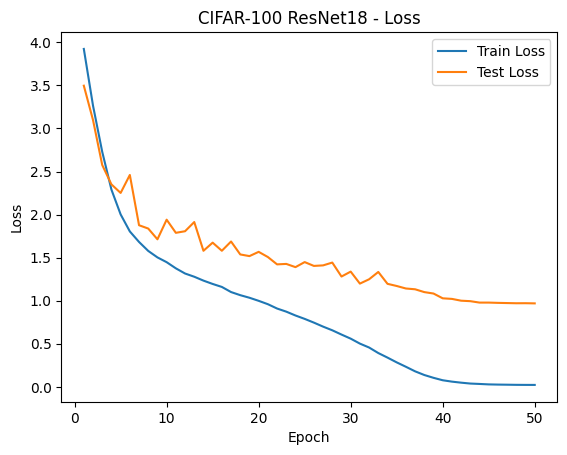

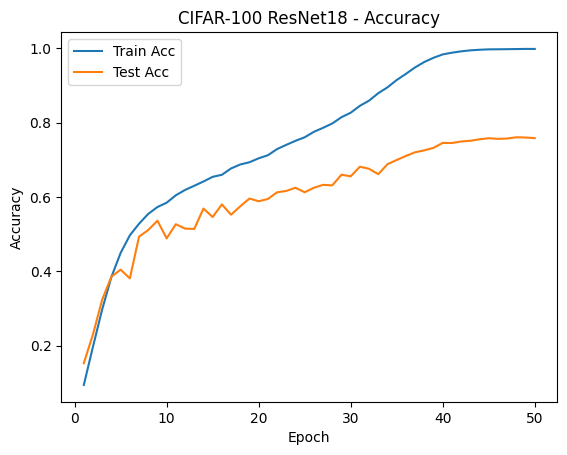

In [ ]:
import matplotlib.pyplot as plt

epochs = range(1, len(train_losses) + 1)

plt.figure()
plt.plot(epochs, train_losses, label="Train Loss")
plt.plot(epochs, test_losses, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("CIFAR-100 ResNet18 - Loss")
plt.show()

plt.figure()
plt.plot(epochs, train_accs, label="Train Acc")
plt.plot(epochs, test_accs, label="Test Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("CIFAR-100 ResNet18 - Accuracy")
plt.show()


In [5]:
model = make_resnet18_cifar100().to(DEVICE)

ckpt = torch.load("./resnet18_cifar100_best-2.pth", map_location=DEVICE)
model.load_state_dict(ckpt["model_state_dict"])
model.eval()


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): Identity()
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), p

In [6]:
import torch.nn.functional as F

class ResNetWithFeatures(nn.Module):
    def __init__(self, backbone):
        super().__init__()
        self.backbone = backbone
        # expose layers explicitly
        self.conv1 = backbone.conv1
        self.bn1 = backbone.bn1
        self.relu = backbone.relu
        self.layer1 = backbone.layer1
        self.layer2 = backbone.layer2
        self.layer3 = backbone.layer3
        self.layer4 = backbone.layer4
        self.avgpool = backbone.avgpool
        self.fc = backbone.fc

    def forward(self, x):
        # copy of ResNet forward, but we return features + logits
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        features = x                            # penultimate features
        logits = self.fc(features)
        return features, logits

feat_model = ResNetWithFeatures(model).to(DEVICE)
feat_model.eval()


ResNetWithFeatures(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): Identity()
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)


In [7]:
@torch.no_grad()
def get_features_and_logits(loader, model, device):
    all_features = []
    all_logits = []
    all_labels = []

    for x, y in loader:
        x = x.to(device)
        features, logits = model(x)
        all_features.append(features.cpu())
        all_logits.append(logits.cpu())
        all_labels.append(y)

    all_features = torch.cat(all_features, dim=0)
    all_logits = torch.cat(all_logits, dim=0)
    all_labels = torch.cat(all_labels, dim=0)
    return all_features, all_logits, all_labels


In [8]:
id_features, id_logits, id_labels = get_features_and_logits(train_loader, feat_model, DEVICE)


In [9]:
def score_msp(logits):
    probs = F.softmax(logits, dim=1)
    return probs.max(dim=1).values  # higher = more in-distribution

def score_max_logit(logits):
    return logits.max(dim=1).values

def score_energy(logits, T=1.0):
    # from Liu et al. "Energy-based OOD detection"
    return T * torch.logsumexp(logits / T, dim=1) # i removed the - sign to be coherent with the other methods


In [ ]:
num_classes = 100
feat_dim = id_features.shape[1]

# Class means in feature space
class_means = torch.zeros(num_classes, feat_dim)
for c in range(num_classes):
    class_feats = id_features[id_labels == c]    
    class_means[c] = class_feats.mean(dim=0)

# Shared covariance 
centered = []
for c in range(num_classes):
    class_feats = id_features[id_labels == c]
    centered.append(class_feats - class_means[c])

centered = torch.cat(centered, dim=0)             
cov = centered.t().mm(centered) / (centered.shape[0] - 1)

# Regularize for numerical stability
eps = 1e-5
cov = cov + eps * torch.eye(feat_dim)

alpha = 0.01  # shrinkage factor

diag_cov = torch.diag(torch.diag(cov))
cov_shrink = (1 - alpha) * cov + alpha * diag_cov

precision = torch.inverse(cov_shrink)



In [ ]:
def mahalanobis_scores(features, class_means, precision):
    """
    features:     (N, D)
    class_means:  (C, D)
    precision:    (D, D)
    returns: (N,) scores (higher ⇒ more ID)
    """
    diff = features.unsqueeze(1) - class_means.unsqueeze(0)
    m_dist2 = torch.einsum('ncd,dd,ncd->nc', diff, precision, diff)
    # nearest class
    min_dist2, _ = m_dist2.min(dim=1)
    # higher score = more ID
    return -min_dist2


In [ ]:
@torch.no_grad()
def get_mahalanobis_scores_for_loader(loader, model, device, class_means, precision):
    all_scores = []
    for x, _ in loader:
        x = x.to(device)
        features, _ = model(x)           
        scores = mahalanobis_scores(features.cpu(), class_means, precision)
        all_scores.append(scores)
    return torch.cat(all_scores, dim=0)


In [13]:
@torch.no_grad()
def get_scores_for_loader(loader, model, device, score_fn):
    scores = []
    for x, _ in loader:
        x = x.to(device)
        _, logits = model(x)
        s = score_fn(logits.cpu())
        scores.append(s)
    return torch.cat(scores, dim=0)


In [12]:
from torchvision.datasets import SVHN

svhn_transform = test_transform  # same normalization

svhn_dataset = SVHN(
    root=DATA_DIR,
    split='test',
    download=True,
    transform=svhn_transform
)

svhn_loader = DataLoader(
    svhn_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=(DEVICE == "cuda")
)


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [13]:
from torchvision.datasets import CIFAR10

cifar10_dataset = CIFAR10(
    root=DATA_DIR,
    train=False,
    download=True,
    transform=test_transform
)

cifar10_loader = DataLoader(
    cifar10_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=(DEVICE == "cuda")
)


In [16]:
# ID = CIFAR-100 test
id_loader = test_loader

id_scores = {
    "MSP":       get_scores_for_loader(id_loader, feat_model, DEVICE, score_msp),
    "MaxLogit":  get_scores_for_loader(id_loader, feat_model, DEVICE, score_max_logit),
    "Energy":    get_scores_for_loader(id_loader, feat_model, DEVICE, score_energy),
    "Mahalanobis":  get_mahalanobis_scores_for_loader(id_loader, feat_model, DEVICE, class_means, precision)
}


ood_scores = {
    "SVHN": {
        "MSP":        get_scores_for_loader(svhn_loader, feat_model, DEVICE, score_msp),
        "MaxLogit":   get_scores_for_loader(svhn_loader, feat_model, DEVICE, score_max_logit),
        "Energy":     get_scores_for_loader(svhn_loader, feat_model, DEVICE, score_energy),
        "Mahalanobis": get_mahalanobis_scores_for_loader(
            svhn_loader, feat_model, DEVICE, class_means, precision
        ),
    },
    "CIFAR-10": {
        "MSP":        get_scores_for_loader(cifar10_loader, feat_model, DEVICE, score_msp),
        "MaxLogit":   get_scores_for_loader(cifar10_loader, feat_model, DEVICE, score_max_logit),
        "Energy":     get_scores_for_loader(cifar10_loader, feat_model, DEVICE, score_energy),
        "Mahalanobis": get_mahalanobis_scores_for_loader(
            cifar10_loader, feat_model, DEVICE, class_means, precision
        ),
    }
}

In [17]:
import numpy as np
from sklearn.metrics import roc_auc_score, average_precision_score


In [18]:
def evaluate_ood(id_scores, ood_scores):
    id_scores = id_scores.numpy()
    ood_scores = ood_scores.numpy()

    y_true = np.concatenate([
        np.ones_like(id_scores),
        np.zeros_like(ood_scores)
    ])

    scores = np.concatenate([id_scores, ood_scores])

    auroc = roc_auc_score(y_true, scores)
    aupr = average_precision_score(y_true, scores)

    # FPR@95%TPR (threshold chosen on ID only)
    threshold = np.percentile(id_scores, 5)   # 95% TPR
    fpr95 = (ood_scores >= threshold).mean()

    return {
        "AUROC": auroc,
        "AUPR": aupr,
        "FPR@95": fpr95
    }


In [19]:
for ood_name, methods in ood_scores.items():
    print(f"\n=== OOD dataset: {ood_name} ===")
    for method, ood_score in methods.items():
        res = evaluate_ood(id_scores[method], ood_score)
        print(
            f"{method:10s} | "
            f"AUROC: {res['AUROC']:.4f} | "
            f"AUPR: {res['AUPR']:.4f} | "
            f"FPR@95: {res['FPR@95']:.4f}"
        )



=== OOD dataset: SVHN ===
MSP        | AUROC: 0.8413 | AUPR: 0.7706 | FPR@95: 0.7180
MaxLogit   | AUROC: 0.8910 | AUPR: 0.8418 | FPR@95: 0.6318
Energy     | AUROC: 0.8952 | AUPR: 0.8467 | FPR@95: 0.6174
Mahalanobis | AUROC: 0.7339 | AUPR: 0.6509 | FPR@95: 0.9327

=== OOD dataset: CIFAR-10 ===
MSP        | AUROC: 0.7644 | AUPR: 0.7921 | FPR@95: 0.8235
MaxLogit   | AUROC: 0.7713 | AUPR: 0.7907 | FPR@95: 0.8225
Energy     | AUROC: 0.7688 | AUPR: 0.7891 | FPR@95: 0.8244
Mahalanobis | AUROC: 0.6644 | AUPR: 0.6636 | FPR@95: 0.9221


In [ ]:
import torch
import torch.nn.functional as F

# Center features
feat_mean = id_features.mean(dim=0, keepdim=True)      
X = id_features - feat_mean                            

# SVD on centered features
U, S, Vh = torch.linalg.svd(X, full_matrices=False)    

# k is the dim of principal subspace
D = X.shape[1]
k = min(512, D // 2)                                   # this was a choice

V = Vh.t()                                             
V_p = V[:, :k]                                         # principal subspace 
V_n = V[:, k:]                                         # null / residual subspace 


In [ ]:
# residual norms for ID data
R = X @ V_n                                            
r_id = torch.norm(R, dim=1)                            

# Compute max logit for ID data
max_logit_id = id_logits.max(dim=1).values            

# we set alpha so that both terms are on similar scale
alpha = (max_logit_id.std() / (r_id.std() + 1e-6)).item()
print("ViM: using k =", k, "alpha =", alpha)


ViM: using k = 256 alpha = 9.883365631103516


In [ ]:
vim_stats = {
    "feat_mean": feat_mean,    # (1, D)
    "V_n": V_n,                # (D, D-k)
    "alpha": alpha
}


In [ ]:
def vim_score(features, logits, feat_mean, V_n, alpha):
    """
    features:  (N, D)
    logits:    (N, C)
    feat_mean: (1, D)
    V_n:       (D, D-k)
    alpha:     scalar
    returns:   (N,) higher ⇒ more ID
    """
    X = features - feat_mean                            # center
    R = X @ V_n                                         
    r_norm = torch.norm(R, dim=1)                      

    max_logit = logits.max(dim=1).values                

    return -alpha * r_norm + max_logit


In [ ]:
@torch.no_grad()
def get_vim_scores_for_loader(loader, model, device, vim_stats):
    all_scores = []
    for x, _ in loader:
        x = x.to(device)
        features, logits = model(x)
        scores = vim_score(
            features.cpu(),
            logits.cpu(),
            vim_stats["feat_mean"],
            vim_stats["V_n"],
            vim_stats["alpha"],
        )
        all_scores.append(scores)
    return torch.cat(all_scores, dim=0)


In [ ]:
id_scores["ViM"] = get_vim_scores_for_loader(
    id_loader, feat_model, DEVICE, vim_stats
)


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
ood_scores["SVHN"]["ViM"] = get_vim_scores_for_loader(
    svhn_loader, feat_model, DEVICE, vim_stats
)

ood_scores["CIFAR-10"]["ViM"] = get_vim_scores_for_loader(
    cifar10_loader, feat_model, DEVICE, vim_stats
)


In [ ]:
for ood_name, methods in ood_scores.items():
    print(f"\n=== OOD dataset: {ood_name} ===")
    for method, ood_score in methods.items():
        res = evaluate_ood(id_scores[method], ood_score)
        print(
            f"{method:10s} | "
            f"AUROC: {res['AUROC']:.4f} | "
            f"AUPR: {res['AUPR']:.4f} | "
            f"FPR@95: {res['FPR@95']:.4f}"
        )



=== OOD dataset: SVHN ===
MSP        | AUROC: 0.8413 | AUPR: 0.7706 | FPR@95: 0.7180
MaxLogit   | AUROC: 0.8910 | AUPR: 0.8418 | FPR@95: 0.6318
Energy     | AUROC: 0.8952 | AUPR: 0.8467 | FPR@95: 0.6174
Mahalanobis | AUROC: 0.7315 | AUPR: 0.6480 | FPR@95: 0.9330
ViM        | AUROC: 0.8611 | AUPR: 0.8151 | FPR@95: 0.7578

=== OOD dataset: CIFAR-10 ===
MSP        | AUROC: 0.7644 | AUPR: 0.7921 | FPR@95: 0.8235
MaxLogit   | AUROC: 0.7713 | AUPR: 0.7907 | FPR@95: 0.8225
Energy     | AUROC: 0.7688 | AUPR: 0.7891 | FPR@95: 0.8244
Mahalanobis | AUROC: 0.6639 | AUPR: 0.6626 | FPR@95: 0.9214
ViM        | AUROC: 0.7271 | AUPR: 0.7413 | FPR@95: 0.8701


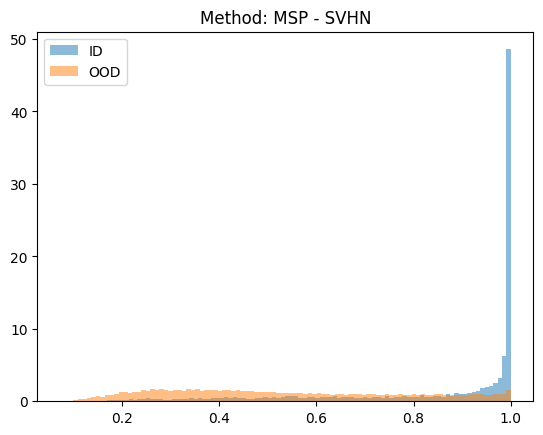

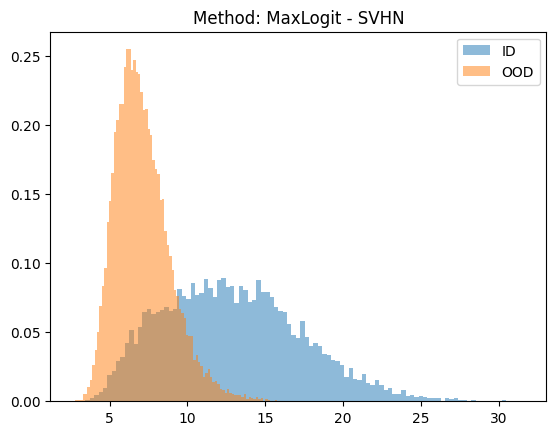

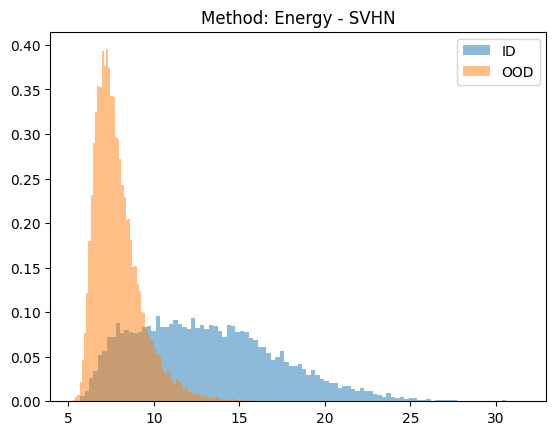

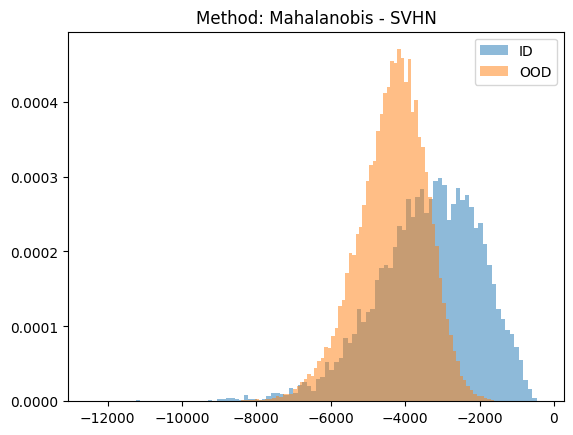

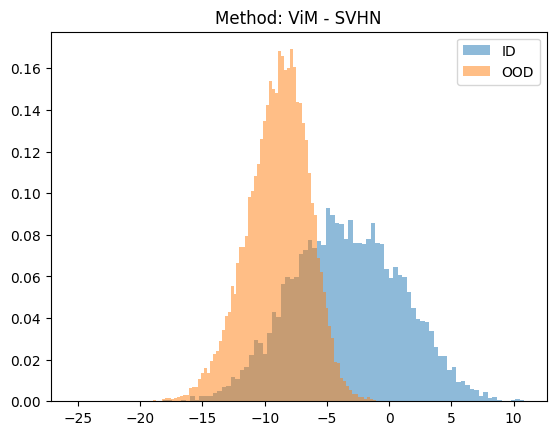

In [ ]:
import matplotlib.pyplot as plt
for method in ["MSP", "MaxLogit", "Energy", "Mahalanobis", "ViM"]:
    plt.figure()

    plt.hist(id_scores[method], bins=100, density=True, alpha=0.5, label="ID")
    plt.hist(ood_scores["SVHN"][method], bins=100, density=True, alpha=0.5, label="OOD")
    plt.legend()
    plt.title(f"Method: {method} - SVHN")
    plt.show()


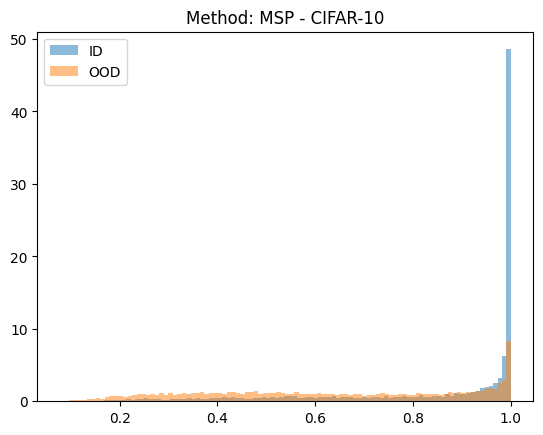

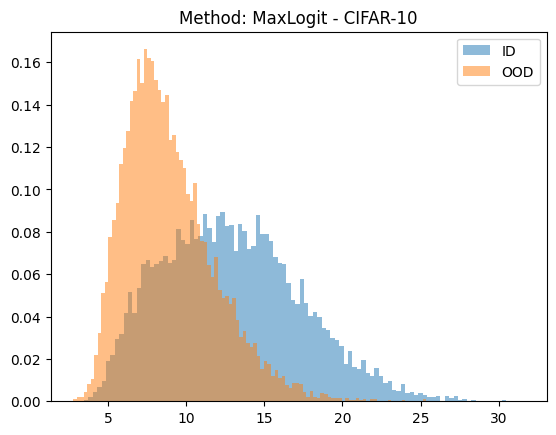

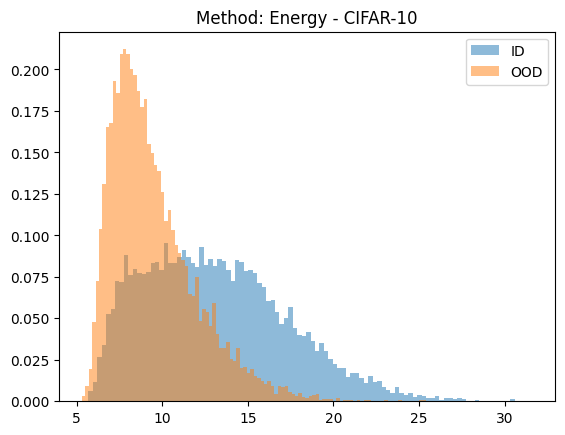

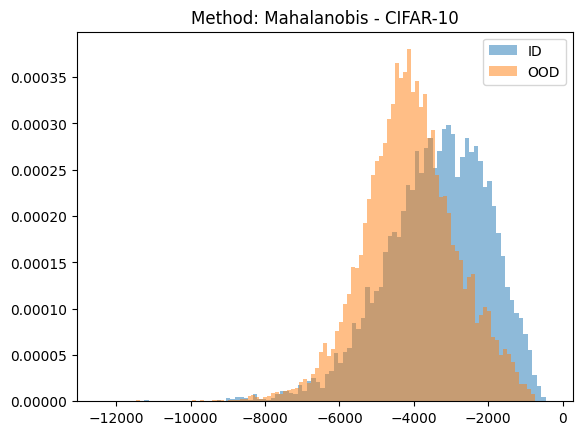

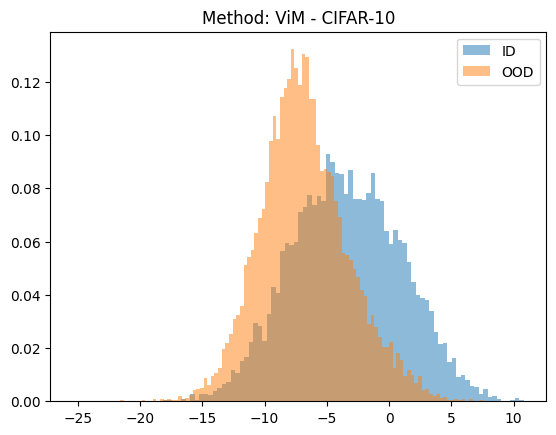

In [ ]:
import matplotlib.pyplot as plt
for method in ["MSP", "MaxLogit", "Energy", "Mahalanobis", "ViM"]:
    plt.figure()

    plt.hist(id_scores[method], bins=100, density=True, alpha=0.5, label="ID")
    plt.hist(ood_scores["CIFAR-10"][method], bins=100, density=True, alpha=0.5, label="OOD")
    plt.legend()
    plt.title(f"Method: {method} - CIFAR-10")
    plt.show()


### Neural collapse

In [ ]:
features = id_features.cpu()
labels = id_labels.cpu()
num_classes = 100
D = features.shape[1]

# Class means 
class_means = []
for c in range(num_classes):
    class_feats = features[labels == c]   
    class_means.append(class_feats.mean(dim=0))
class_means = torch.stack(class_means, dim=0)   

global_mean = features.mean(dim=0)              

W = model.fc.weight.data.cpu()                  
b = model.fc.bias.data.cpu()                   


In [ ]:
# Within-class variance
within_vars = []
for c in range(num_classes):
    class_feats = features[labels == c]
    diffs = class_feats - class_means[c]        
    sq_norms = (diffs ** 2).sum(dim=1)         
    within_vars.append(sq_norms.mean())
within_vars = torch.stack(within_vars)        
within_mean = within_vars.mean().item()

# Between-class variance
between_diffs = class_means - global_mean     
between_sq = (between_diffs ** 2).sum(dim=1)   
between_mean = between_sq.mean().item()

nc1_ratio = within_mean / (between_mean + 1e-8)

print("NC1 – within-class var (avg):", within_mean)
print("NC1 – between-class var (avg):", between_mean)
print("NC1 – ratio within/between:", nc1_ratio)


NC1 – within-class var (avg): 47.35401916503906
NC1 – between-class var (avg): 71.91551971435547
NC1 – ratio within/between: 0.6584673147957768


In [ ]:
# NC2

# Center class means by global mean
centered_means = class_means - global_mean           

# Norms of centered class means
mean_norms = centered_means.norm(dim=1)              
print("NC2 – mean of ‖μ_c - μ‖:", mean_norms.mean().item())
print("NC2 – std  of ‖μ_c - μ‖:", mean_norms.std().item())

# Normalize centered means
means_unit = centered_means / (mean_norms.unsqueeze(1) + 1e-8)  

# Gram matrix of cosines
G_mu = means_unit @ means_unit.t()                    

diag_mu = G_mu.diag()                                
mask_off = ~torch.eye(num_classes, dtype=torch.bool)
off_mu = G_mu[mask_off]

print("NC2 – diag mean (should be ~1):", diag_mu.mean().item())
print("NC2 – off-diag mean (≈ -1/(C-1)):", off_mu.mean().item())
print("NC2 – off-diag std:", off_mu.std().item())


NC2 – mean of ‖μ_c - μ‖: 8.463364601135254
NC2 – std  of ‖μ_c - μ‖: 0.5384101271629333
NC2 – diag mean (should be ~1): 1.0
NC2 – off-diag mean (≈ -1/(C-1)): -0.010025588795542717
NC2 – off-diag std: 0.12252034991979599


In [ ]:
# Normalize weights
W_norms = W.norm(dim=1)
W_unit = W / (W_norms.unsqueeze(1) + 1e-8)

cos_w_mu = (W_unit * means_unit).sum(dim=1)   

print("NC3 – mean cos(w_c, μ_c):", cos_w_mu.mean().item())
print("NC3 – std  cos(w_c, μ_c):", cos_w_mu.std().item())
print("NC3 – min  cos(w_c, μ_c):", cos_w_mu.min().item())
print("NC3 – max  cos(w_c, μ_c):", cos_w_mu.max().item())


NC3 – mean cos(w_c, μ_c): 0.9385532140731812
NC3 – std  cos(w_c, μ_c): 0.01603691093623638
NC3 – min  cos(w_c, μ_c): 0.8870341181755066
NC3 – max  cos(w_c, μ_c): 0.9659286737442017


In [ ]:
id_features, id_logits, id_labels = get_features_and_logits(train_loader, feat_model, DEVICE)
logits = id_logits.cpu()    
labels = id_labels.cpu()    
N, C = logits.shape


In [ ]:
import torch

# 1) Get ID features/logits/labels on TRAIN set (for class means)
id_train_features, id_train_logits, id_train_labels = get_features_and_logits(
    train_loader, feat_model, DEVICE
)
id_train_features = id_train_features.cpu()
id_train_logits   = id_train_logits.cpu()
id_train_labels   = id_train_labels.cpu()

num_classes = id_train_logits.shape[1]
D = id_train_features.shape[1]

# 2) Compute class means in feature space (using TRAIN data)
class_means = []
for c in range(num_classes):
    feats_c = id_train_features[id_train_labels == c]   
    class_means.append(feats_c.mean(dim=0))
class_means = torch.stack(class_means, dim=0)       


@torch.no_grad()
def nearest_class_center_predictions(features, class_means):
    """
    features: (N, D) tensor
    class_means: (C, D) tensor
    returns: (N,) NCC predicted labels
    """
    # (N, C, D)
    diff = features.unsqueeze(1) - class_means.unsqueeze(0)
    dist2 = (diff ** 2).sum(dim=2)             
    preds_ncc = dist2.argmin(dim=1)         
    return preds_ncc


# 3) Evaluate NC4 on TEST set
id_test_features, id_test_logits, id_test_labels = get_features_and_logits(
    test_loader, feat_model, DEVICE
)
id_test_features = id_test_features.cpu()
id_test_logits   = id_test_logits.cpu()
id_test_labels   = id_test_labels.cpu()

# Network predictions (linear classifier)
pred_net = id_test_logits.argmax(dim=1)

# NCC predictions
pred_ncc = nearest_class_center_predictions(id_test_features, class_means)

# Accuracies
acc_net  = (pred_net == id_test_labels).float().mean().item()
acc_ncc  = (pred_ncc == id_test_labels).float().mean().item()

# Agreement between the two decision rules
agreement = (pred_net == pred_ncc).float().mean().item()

print(f"NC4 – test accuracy (network): {acc_net*100:.2f}%")
print(f"NC4 – test accuracy (NCC):      {acc_ncc*100:.2f}%")
print(f"NC4 – decision agreement:       {agreement*100:.2f}%")


NC4 – test accuracy (network): 76.07%
NC4 – test accuracy (NCC):      75.56%
NC4 – decision agreement:       93.81%


In [18]:
def nc5_orthogonality_from_mean(class_means, mu_ood):
    """
    class_means: (C, D) tensor on CPU
    mu_ood:      (D,)   tensor on CPU
    """
    mu_ood_norm = mu_ood.norm() + 1e-8
    mu_c_norms  = class_means.norm(dim=1) + 1e-8

    # per-class cosines
    cos_per_class = (class_means @ mu_ood) / (mu_c_norms * mu_ood_norm)  # (C,)

    stats = {
        "cos_per_class": cos_per_class,
        "cos_mean": cos_per_class.mean().item(),
        "cos_std":  cos_per_class.std().item(),
        "ortho_dev": cos_per_class.abs().mean().item(),
    }
    return stats


In [ ]:
import torch

@torch.no_grad()
def get_global_mean_features(loader, model, device):
    """
    Compute global mean of penultimate features over a loader,
    without storing all features in memory.
    """
    running_sum = None
    total = 0

    model.eval()
    for x, _ in loader:
        x = x.to(device, non_blocking=True)
        feats, _ = model(x)        # (B, D) on device
        feats = feats.detach().cpu()

        if running_sum is None:
            running_sum = feats.sum(dim=0)
        else:
            running_sum += feats.sum(dim=0)

        total += feats.size(0)

        del x, feats

    mu = running_sum / total
    return mu        


In [16]:
ood_loaders = {
    "SVHN": svhn_loader,
    "CIFAR-10": cifar10_loader,
}


In [ ]:
torch.cuda.empty_cache()

ood_loaders = {
    "SVHN": svhn_loader,
    "CIFAR10": cifar10_loader,
}

results_nc5 = {}

for name, loader in ood_loaders.items():
    print(f"Computing NC5 stats for {name}...")
    mu_G_ood = get_global_mean_features(loader, feat_model, DEVICE)  
    res = nc5_orthogonality_from_mean(class_means, mu_G_ood)
    results_nc5[name] = res

for name, res in results_nc5.items():
    print(f"\nNC5 – ID/OOD orthogonality ({name})")
    print(f"  mean cos(μ_c, μ_G^OOD):  {res['cos_mean']:.4f}")
    print(f"  std  cos(μ_c, μ_G^OOD):  {res['cos_std']:.4f}")
    print(f"  OrthoDev_classes-OOD:    {res['ortho_dev']:.4f}")


Computing NC5 stats for SVHN...


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Computing NC5 stats for CIFAR10...

NC5 – ID/OOD orthogonality (SVHN)
  mean cos(μ_c, μ_G^OOD):  0.5234
  std  cos(μ_c, μ_G^OOD):  0.0719
  OrthoDev_classes-OOD:    0.5234

NC5 – ID/OOD orthogonality (CIFAR10)
  mean cos(μ_c, μ_G^OOD):  0.6457
  std  cos(μ_c, μ_G^OOD):  0.0649
  OrthoDev_classes-OOD:    0.6457


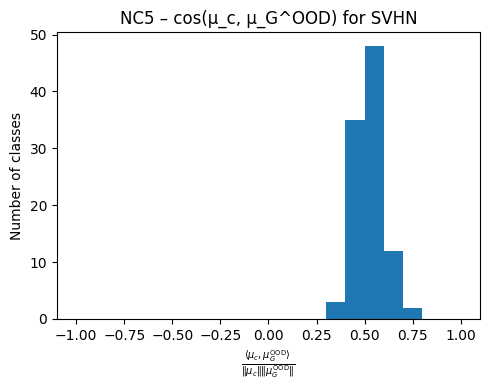

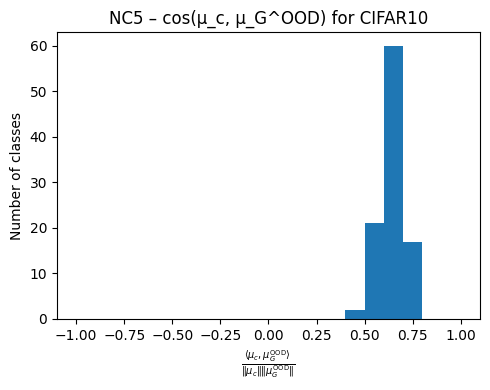

In [20]:
import matplotlib.pyplot as plt

for name, res in results_nc5.items():
    cos_c = res["cos_per_class"]
    plt.figure(figsize=(5,4))
    plt.hist(cos_c.numpy(), bins=20, range=(-1, 1))
    plt.title(f"NC5 – cos(μ_c, μ_G^OOD) for {name}")
    plt.xlabel(r"$\frac{\langle \mu_c, \mu_G^{\text{OOD}} \rangle}{\|\mu_c\| \|\mu_G^{\text{OOD}}\|}$")
    plt.ylabel("Number of classes")
    plt.tight_layout()
    plt.show()


### NECO method

In [ ]:
import torch

features_id = id_features.cpu()  

def compute_neco_P(features, k_neco=150):
    """
    Compute PCA basis (top k_neco components) for NECO.
    features: (N, D) tensor.
    returns P: (k_neco, D) with orthonormal rows.
    """
    X = features - features.mean(dim=0, keepdim=True)   

    # We only need the top k_right singular vectors (rows of Vh)
    U, S, Vh = torch.linalg.svd(X, full_matrices=False) 

    k = min(k_neco, Vh.shape[0])
    P = Vh[:k, :]  

    return P

P_neco = compute_neco_P(features_id, k_neco=150)
P_neco = P_neco.to(DEVICE)  


In [ ]:
def score_neco(feats, logits):
    """
    feats:  (B, D) penultimate features h(x)
    logits: (B, C) logits f(x)
    returns: (B,) NECO scores (higher = more ID)
    """
    # Project onto NC subspace
    proj = feats @ P_neco.t()                

    # Geometric NC ratio
    neco_geom = proj.norm(dim=1) / (feats.norm(dim=1) + 1e-8)

    # NC5 injection: max logit
    max_logit = logits.max(dim=1).values

    return neco_geom * max_logit


In [ ]:
@torch.no_grad()
def get_neco_scores_for_loader(loader, model, device):
    all_scores = []
    for x, _ in loader:
        x = x.to(device)
        feats, logits = model(x)
        scores = score_neco(feats, logits)
        all_scores.append(scores.cpu())
    return torch.cat(all_scores, dim=0)


In [ ]:
id_scores["NECO"] = get_neco_scores_for_loader(
    id_loader, feat_model, DEVICE
)


In [ ]:
ood_scores["SVHN"]["NECO"] = get_neco_scores_for_loader(
    svhn_loader, feat_model, DEVICE
)

ood_scores["CIFAR-10"]["NECO"] = get_neco_scores_for_loader(
    cifar10_loader, feat_model, DEVICE
)


In [ ]:
for ood_name, methods in ood_scores.items():
    print(f"\n=== OOD dataset: {ood_name} ===")
    for method, ood_score in methods.items():
        res = evaluate_ood(id_scores[method], ood_score)
        print(
            f"{method:10s} | "
            f"AUROC: {res['AUROC']:.4f} | "
            f"AUPR: {res['AUPR']:.4f} | "
            f"FPR@95: {res['FPR@95']:.4f}"
        )



=== OOD dataset: SVHN ===
MSP        | AUROC: 0.8413 | AUPR: 0.7706 | FPR@95: 0.7180
MaxLogit   | AUROC: 0.8910 | AUPR: 0.8418 | FPR@95: 0.6318
Energy     | AUROC: 0.8952 | AUPR: 0.8467 | FPR@95: 0.6174
Mahalanobis | AUROC: 0.7315 | AUPR: 0.6480 | FPR@95: 0.9330
ViM        | AUROC: 0.8611 | AUPR: 0.8151 | FPR@95: 0.7578
NECO       | AUROC: 0.8922 | AUPR: 0.8438 | FPR@95: 0.6262

=== OOD dataset: CIFAR-10 ===
MSP        | AUROC: 0.7644 | AUPR: 0.7921 | FPR@95: 0.8235
MaxLogit   | AUROC: 0.7713 | AUPR: 0.7907 | FPR@95: 0.8225
Energy     | AUROC: 0.7688 | AUPR: 0.7891 | FPR@95: 0.8244
Mahalanobis | AUROC: 0.6639 | AUPR: 0.6626 | FPR@95: 0.9214
ViM        | AUROC: 0.7271 | AUPR: 0.7413 | FPR@95: 0.8701
NECO       | AUROC: 0.7715 | AUPR: 0.7908 | FPR@95: 0.8212


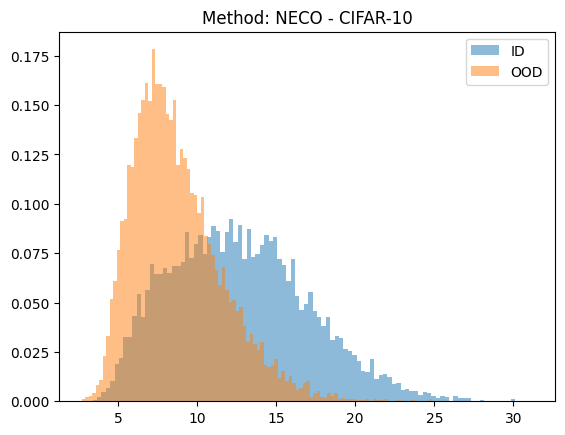

In [ ]:
plt.figure()
method = "NECO"
plt.hist(id_scores[method], bins=100, density=True, alpha=0.5, label="ID")
plt.hist(ood_scores["CIFAR-10"][method], bins=100, density=True, alpha=0.5, label="OOD")
plt.legend()
plt.title(f"Method: {method} - CIFAR-10")
plt.show()

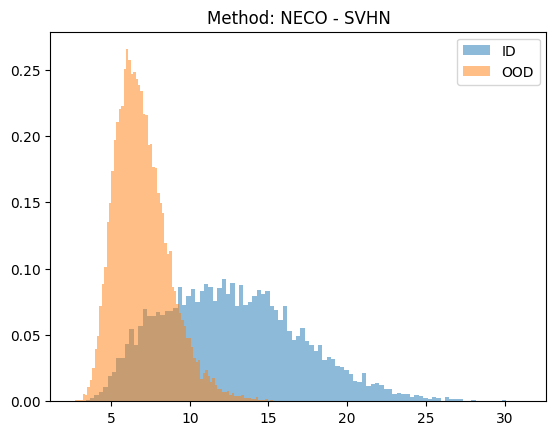

In [ ]:
plt.figure()
method = "NECO"
plt.hist(id_scores[method], bins=100, density=True, alpha=0.5, label="ID")
plt.hist(ood_scores["SVHN"][method], bins=100, density=True, alpha=0.5, label="OOD")
plt.legend()
plt.title(f"Method: {method} - SVHN")
plt.show()

FINAL PLOTS

In [ ]:
features = id_features.cpu()        
labels   = id_labels.cpu()          
W        = model.fc.weight.data.cpu()  
num_classes = 100

# Class means
class_means = torch.stack([
    features[labels == c].mean(dim=0)
    for c in range(num_classes)
], dim=0)  

global_mean = features.mean(dim=0)


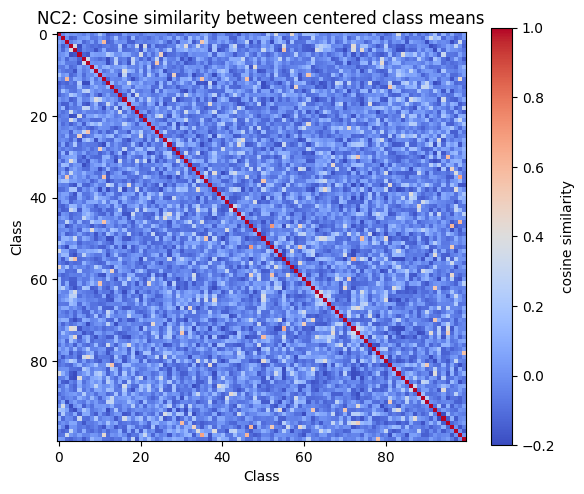

In [ ]:
import matplotlib.pyplot as plt
import torch

# Center means
centered_means = class_means - global_mean

# Normalize
means_unit = centered_means / (
    centered_means.norm(dim=1, keepdim=True) + 1e-8
)

# Cosine similarity matrix
G_mu = means_unit @ means_unit.t()   

plt.figure(figsize=(6, 5))
plt.imshow(G_mu.numpy(), cmap="coolwarm", vmin=-0.2, vmax=1.0)
plt.colorbar(label="cosine similarity")
plt.title("NC2: Cosine similarity between centered class means")
plt.xlabel("Class")
plt.ylabel("Class")
plt.tight_layout()
plt.show()


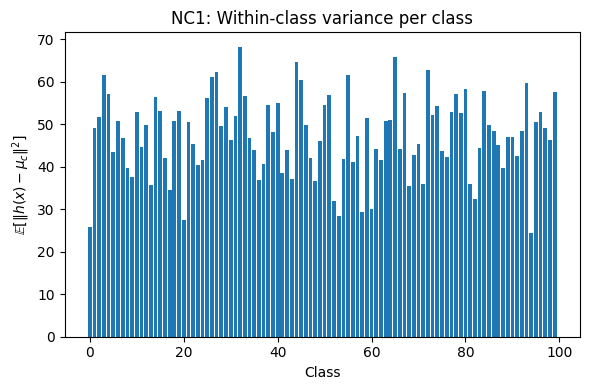

In [43]:
within_vars = []

for c in range(num_classes):
    class_feats = features[labels == c]
    diffs = class_feats - class_means[c]
    sq_norms = (diffs ** 2).sum(dim=1)
    within_vars.append(sq_norms.mean().item())

within_vars = torch.tensor(within_vars)

plt.figure(figsize=(6, 4))
plt.bar(range(num_classes), within_vars.numpy())
plt.title("NC1: Within-class variance per class")
plt.xlabel("Class")
plt.ylabel(r"$\mathbb{E}[\|h(x)-\mu_c\|^2]$")
plt.tight_layout()
plt.show()


/tmp/ipython-input-2949575784.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([within_vars.numpy(), between_vars.numpy()],


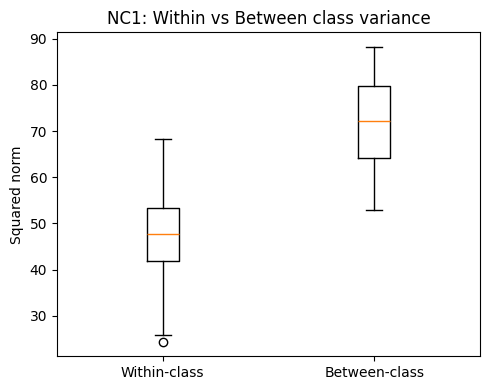

In [42]:
between_diffs = class_means - global_mean
between_vars = (between_diffs ** 2).sum(dim=1)

plt.figure(figsize=(5, 4))
plt.boxplot([within_vars.numpy(), between_vars.numpy()],
            labels=["Within-class", "Between-class"])
plt.title("NC1: Within vs Between class variance")
plt.ylabel("Squared norm")
plt.tight_layout()
plt.show()


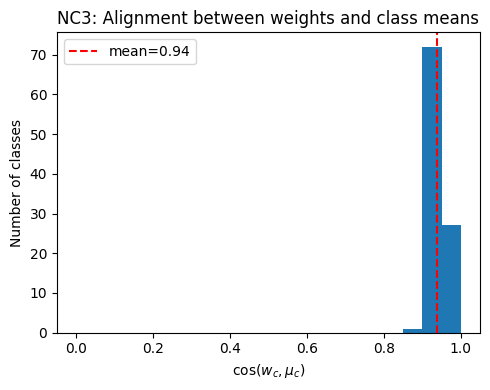

In [41]:

plt.figure(figsize=(5, 4))
plt.hist(cos_w_mu.numpy(), bins=20, range=(0, 1))
plt.axvline(cos_w_mu.mean().item(), color="red", linestyle="--",
            label=f"mean={cos_w_mu.mean():.2f}")
plt.xlabel(r"$\cos(w_c, \mu_c)$")
plt.ylabel("Number of classes")
plt.title("NC3: Alignment between weights and class means")
plt.legend()
plt.tight_layout()
plt.show()
